This notebook trains a flow in weight-space for classification on MNIST.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys

# sys.path.insert(1, "/dss/dsshome1/0E/di38seq/weight-generation")
sys.path.insert(1, "..")


import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torchdiffeq import odeint
from tqdm import tqdm

import flow.flow_matching as fm
from flow.forces import get_force_field
from nn.gnn import GNNForClassification
from nn.graph_constructor import GraphConstructor
from nn.mlp import MLP
from nn.relational_transformer import RelationalTransformer
from utils.data import (
    WeightDataset,
    count_parameters,
    load_weights,
    sample_gaussian_wsos,
)
from utils.eval import (
    FlowEvaluator,
)
from utils.plots import plot_hists
from utils.results import get_taskloaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cpu


### Load weights

We first load the weights collected over SGD trajectories. 

In [ ]:
data_path = "../data"

batch_size = 8

# whether to normalize (map to the product of hyperspheres) the loaded weights
normalize = False

# std for the source distribution (p_0) of the flow model
source_std = 1

TASK = "MNIST"  # "REGRESSION", "MNIST"

filepath = f"{data_path}/aligned_mnist_normal_10.h5"
input_dim, hidden_dims, output_dim = 784, [10], 10

trainloader, testloader = get_taskloaders(TASK)

weightloader, layer_layout = load_weights(
    filepath=filepath,
    batch_size=batch_size,
    layers=[input_dim] + hidden_dims + [output_dim],
)

target_weights = weightloader.dataset.objects
n = len(target_weights)
layer_layout

Loading data: 100%|██████████| 58600/58600 [00:04<00:00, 13536.52it/s]


[784, 10, 10]

In [ ]:
# sample from p_0
source_weights = sample_gaussian_wsos(
    weightloader.dataset.objects[0] * 0,
    std=source_std,
    n=len(weightloader.dataset.objects),
)

if normalize:
    for wso in tqdm(target_weights + source_weights):
        wso.normalize()

sourceloader = torch.utils.data.DataLoader(
    WeightDataset(source_weights, labels=None),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

weightloader = torch.utils.data.DataLoader(
    WeightDataset(target_weights, labels=None),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

# init the base model
model = MLP(
    input_size=input_dim,
    hidden_sizes=hidden_dims,
    output_size=output_dim,
    activation="relu",
).to(device)

### Set up the flow model 

Geometric: False
mlp params 7960
gnn params 12293


Iters [loss 0.080776, ∇ norm 0.531519]: 100%|██████████| 8/8 [03:25<00:00, 25.72s/it]


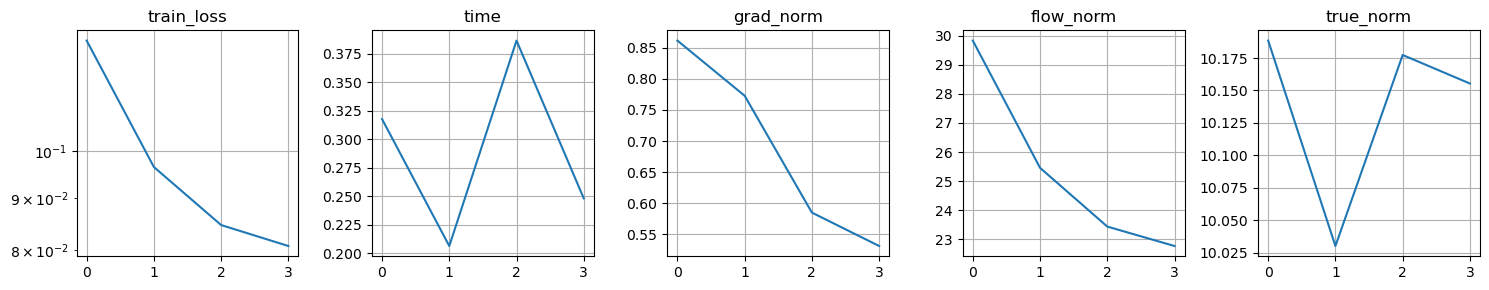

In [ ]:
# dimension of input features, one for one weight/bias per edge/node.
d_feat = 1

# node/edge feature dimension, projected up from one-dimensional weights/biases.
d_embed = 8

# number of layers (i.e. message-passing steps)
n_layers = 3

# number of attention heads for the relational transformer
n_heads = 1

model_type = "transformer"  # "transformer", "mpnn"

print("Geometric:", normalize)

#
flow_graph_constructor = GraphConstructor(
    d_in=d_feat,
    d_edge_in=d_feat,
    d_node=d_embed,
    d_edge=d_embed,
    layer_layout=layer_layout,
    use_pos_embed=False,
    in_proj_layers=3,
    num_probe_features=0,
    rev_edge_features=False,
    stats=None,
)

extended_layout = [0] + layer_layout
deg = torch.zeros(max(extended_layout) + 1, dtype=torch.long)
for li in range(len(extended_layout) - 1):
    deg[extended_layout[li]] += extended_layout[li + 1]

if model_type == "mpnn":
    flow_model = GNNForClassification(
        d_hid=d_embed + 1,  # + 1 for time
        d_out=1,  # output one feature per node/edge
        n_batch=batch_size,
        graph_constructor=flow_graph_constructor,
        backbone="PNA",
        deg=deg,
        n_layers=n_layers,
        device=device,
        layer_layout=layer_layout,
        rev_edge_features=False,
        pooling_method="cat",
        pooling_layer_idx="last",
        task_level="edge_node",
        refine=False,
    ).to(device)
else:
    flow_model = RelationalTransformer(
        d_node=d_embed + 1,
        d_edge=d_embed + 1,
        d_attn_hid=d_embed,
        d_node_hid=d_embed,
        d_edge_hid=d_embed,
        d_out_hid=d_embed,
        d_out=1,
        n_layers=n_layers,
        n_heads=n_heads,
        n_batch=batch_size,
        layer_layout=layer_layout,
        graph_constructor=flow_graph_constructor,
        dropout=0.0,
        node_update_type="rt",
        use_cls_token=False,
        pooling_method="cat",
        pooling_layer_idx="last",
        rev_edge_features=False,
        modulate_v=True,
        use_ln=True,
        tfixit_init=False,
        task_level="edge_node",
        device=device,
        refine=False,
    )

flow_model.train()

n_params_base = count_parameters(model)
n_params_gnn = count_parameters(flow_model)
print("mlp params", n_params_base)
print("gnn params", n_params_gnn)

optimizer = torch.optim.Adam(flow_model.parameters(), lr=0.001)

cfm = fm.CFM(
    sourceloader=sourceloader,
    targetloader=weightloader,
    device=device,
    layer_layout=np.array(layer_layout),
    model=flow_model,
    fm_type="vanilla",  # coupling (vanilla (indpendent), or ot)
    mode="target",  # predict 'target' (x_1) or 'velocity' (u_t)
    normalize_pred=normalize,  # map predictions to the product geometry (only viable for x_1 prediction)
    geometric=normalize,  # define flow over the product geometry
    t_dist="beta",  # beta or uniform, distribution to sample time in [0,1]
)

cfm.train(
    n_iters=8,  # number of training steps
    optimizer=optimizer,
    sigma=0.001,  # std for the intermediate distributions p_t
    patience=1e99,
    log_freq=2,
)

cfm.plot_metrics()

Plot average time and loss per batch. Early time points incur higher losses, and by sampling $t \sim \text{Beta}(1,2)$ we optimize at those points for more steps. 

/var/folders/17/ksjp4vcn2gs552rnysdxktrc0000gn/T/ipykernel_8274/3231893985.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("inferno", len(cfm.metrics["time"]))


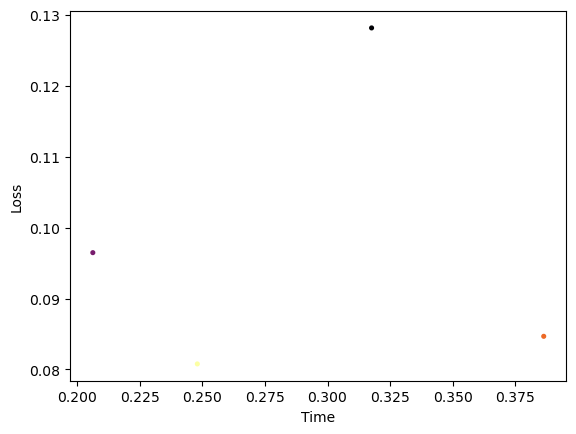

In [ ]:
cmap = cm.get_cmap("inferno", len(cfm.metrics["time"]))
colors = cmap(np.linspace(0, 1, len(cfm.metrics["time"])))
plt.scatter(cfm.metrics["time"], cfm.metrics["train_loss"], c=colors, s=7)
plt.xlabel("Time")
plt.ylabel("Loss")
plt.show()

### Analysis

Map samples from $p_0$ with the flow to approximate $p_1$

We first init a `FlowEvaluator` object to handle the mapping and evaluation of samples.

In [ ]:
cfm.force_field = get_force_field(
    model,
    layer_layout,
    trainloader,
    batch_size,
    device,
    loss_fn=torch.nn.CrossEntropyLoss(),
)

# strength of the 'force field' (e.g. gradients from the base task)
cfm.lambda_f = 0

# True is the base task is classification, False for regression
CLASSIFICATION = True

evaluator = FlowEvaluator(
    cfm=cfm,
    flow_sourceloader=sourceloader,
    flow_targetloader=weightloader,
    nn_testloader=testloader,
    classification=CLASSIFICATION,
    layers=layer_layout,
    nn_model=model,
    y_scaler=None,
)

In [ ]:
# number of batches to map
n_batches = 4
n = n_batches * batch_size

# number of euler steps to solve the flow ODE
n_steps = 20

mapped_wsos = evaluator.map(n_steps=n_steps, n_batches=n_batches)
losses, accs = evaluator.get_losses_accs(mapped_wsos, n=n)
distances = evaluator.get_distances(mapped_wsos, n=n)

eval mapped: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]
eval src/target: 32it [00:14,  2.17it/s]


In [ ]:
print("Loss")
print(
    "Source",
    f"{np.array(evaluator.source_losses).mean():.2f} ± {np.array(evaluator.source_losses).std():.2f}",
)
print("Mapped", f"{np.array(losses).mean():.2f} ± {np.array(losses).std():.2f}")
print(
    "Target",
    f"{np.array(evaluator.target_losses).mean():.2f} ± {np.array(evaluator.target_losses).std():.2f}",
)

print("Acc")
print(
    "Source",
    f"{np.array(evaluator.source_accs).mean():.2f} ± {np.array(evaluator.source_accs).std():.2f}",
)
print("Mapped", f"{np.array(accs).mean():.2f} ± {np.array(accs).std():.2f}")
print(
    "Target",
    f"{np.array(evaluator.target_accs).mean():.2f} ± {np.array(evaluator.target_accs).std():.2f}",
)

Loss
Source 89.38 ± 20.35
Mapped 2.32 ± 0.03
Target 0.24 ± 0.02
Acc
Source 0.10 ± 0.03
Mapped 0.10 ± 0.03
Target 0.93 ± 0.01


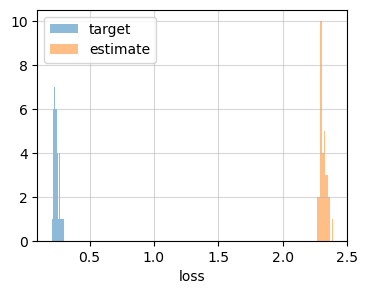

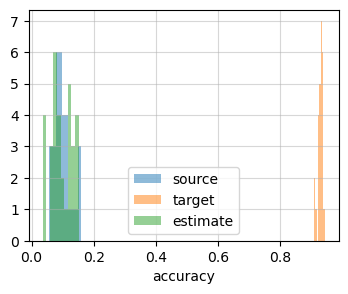

In [ ]:
plot_hists(
    [evaluator.target_losses, losses],
    ["target", "estimate"],
    size=(4, 3),
    xlabel="loss",
)

if CLASSIFICATION:
    plot_hists(
        [evaluator.source_accs, evaluator.target_accs, accs],
        ["source", "target", "estimate"],
        size=(4, 3),
        xlabel="accuracy",
    )

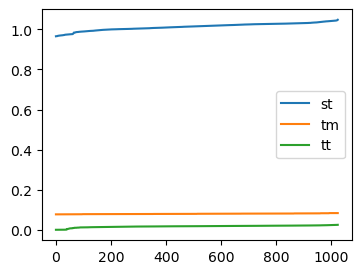

In [ ]:
# pairwise distances between weights from the (s)ource, (t)arget, and (m)apped distributions
plt.figure(figsize=(4, 3))
for k, v in distances.items():
    if k in ["tt", "tm", "st"]:
        plt.plot(range(len(v)), sorted(v), label=k)
plt.legend()
plt.show()

### Sample weights and estimate likelihoods

In [ ]:
# integration steps
n_steps = 20

# 'hutchinson' estimator or 'exact' Jacobian trace
trace_method = "hutchinson"

for batch in sourceloader:
    x0 = batch.flatten(keep_n_batch=True).to(device)
    ode = cfm.get_ode(x0, trace=trace_method, nfe=20)
    ladj_0 = torch.zeros(batch_size).to(device)
    z, ladj = odeint(
        ode,
        (x0, ladj_0),
        torch.tensor([0, 1]).to(ladj_0),
        options={"step_size": 1 / n_steps},
        method="euler",
    )
    break  # do as an example for one batch

In [ ]:
x0, x1 = z[0], z[1]
ladj_0, ladj_1 = ladj[0], ladj[1]

p0 = MultivariateNormal(
    torch.zeros_like(x1[0]), torch.eye(x1.size(1)).to(device) * source_std
)

print("log p_0(x_0):", p0.log_prob(x0))
print("log p_1_est(x_1):", p0.log_prob(x0) - ladj_1)